In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

In [15]:
from skimage import io, filters
from scipy.interpolate import interpn
from scipy.optimize import minimize

# One element DIC

1. load images
2. Select area
3. blur the images (gaussian filter)
4. Affine transformation of a patch
5. Interpolation
6. optimization

In [3]:
# List images
image_pattern = './Sample#2/Top_*'

def get_number(name):
    '''Extract all digits from given name'''
    # https://stackoverflow.com/a/36434101/8069403
    return int(''.join(filter(str.isdigit, name)))

image_list = sorted(glob(image_pattern),
                    key=get_number)

print(len(image_list), 'images found:')
print(', '.join(image_list[:3]) + ', ...,  ' +  image_list[-1])

# Loads images
images = [io.imread(filename, as_gray=True) for filename in image_list]

16 images found:
./Sample#2/Top_snap0 .png, ./Sample#2/Top_snap1 .png, ./Sample#2/Top_snap2 .png, ...,  ./Sample#2/Top_snap15 .png


In [75]:
# Image selection
k = 0
I, J = images[k:k+2]

# Define a box area
# bottom left corner, and width, height
x, y, w, h = 600, 500, 70, 70
box = x, y, w, h

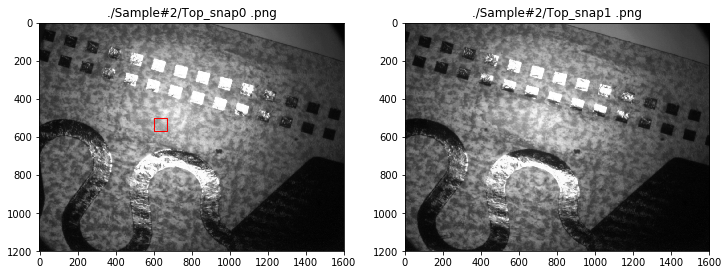

In [76]:
box_polyline = np.array([[x, x+w, x+w, x, x],
                         [y, y, y+h, y+h, y]]).T

# Graph
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(I, cmap = 'gray');
ax2.imshow(J, cmap = 'gray');
ax1.set_title(image_list[k]);
ax2.set_title(image_list[k+1]);
ax1.plot(box_polyline[:, 0], box_polyline[:, 1],
         '-', color='red', linewidth=1, label='box');

In [77]:
# Define an affine transformation
# translation + transformation matrix

def affine(xy, A):
    dxy = xy - xy[0, :]

    xy_prime = np.einsum('ij, ik', A[:, 1:], dxy.T).T
    xy_prime += xy[0, :] + A[:, 0]
    return xy_prime

In [78]:
def back_transform(box, A, I, J):
    """
    inputs
        box: x, y, w, h
        smoothed images: I, J
        transformation: tr, A
    returns
        I_box
        J_box (interpolated)
        """
    x, y, w, h = box
    
    # List pixels coords of the box
    x_grid, y_grid = np.meshgrid(np.arange(x, x+w), np.arange(y, y+h))
    xy_list = np.vstack([x_grid.flatten(), y_grid.flatten()]).T

    # Apply the transformation to the pixel grid
    xy_prime_list = affine(xy_list, A)

    # Interpolation of the image at the point of the transformed grid
    x_span, y_span = np.arange(J.shape[0]), np.arange(J.shape[1])
    J_prime_list = interpn((y_span, x_span), J.T, xy_prime_list,
                           method='splinef2d')
    J_prime_grid = J_prime_list.reshape(x_grid.shape)
    
    I_box = I[y:y+h, x:x+w]
    return I_box, J_prime_grid

In [79]:
def normalize(I):
    return (I - I.mean())/I.std()

def znssd(I, J):
    """Zero-normalized sum of squared differences (ZNSSD)"""
    return np.sum( (normalize(I) - normalize(J))**2 )

In [103]:
# blur
sigma = 10
I_blur, J_blur = (filters.gaussian(img, sigma=sigma) for img in (I, J))

In [104]:
# Transformation
A_init = np.array([[-46, 1., 0.], [-5, 0., 1]])

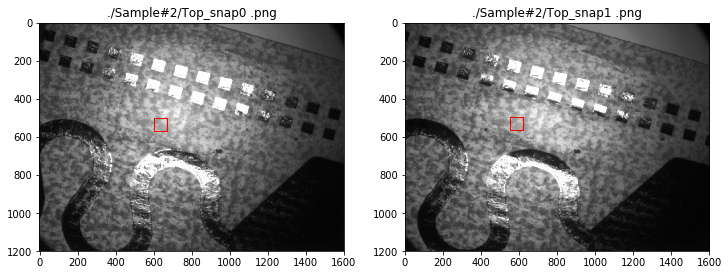

In [105]:
box_polyline = np.array([[x, x+w, x+w, x, x],
                         [y, y, y+h, y+h, y]]).T

box_prime = affine(box_polyline, A_init)

# Graph
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(I, cmap = 'gray');
ax2.imshow(J, cmap = 'gray');
ax1.set_title(image_list[k]);
ax2.set_title(image_list[k+1]);
ax1.plot(box_polyline[:, 0], box_polyline[:, 1],
         '-', color='red', linewidth=1, label='box');
ax2.plot(box_prime[:, 0], box_prime[:, 1],
         '-', color='red', linewidth=1, label='box');

In [106]:
Ibox, Jbox = back_transform(box, A_init, I_blur, J_blur)

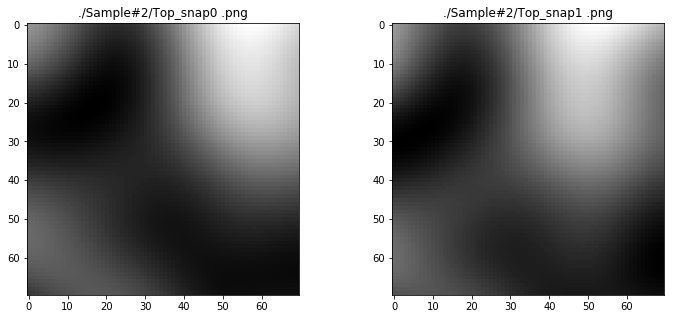

In [107]:
# Graph
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(normalize(Ibox), cmap = 'gray');
ax2.imshow(normalize(Jbox), cmap = 'gray');
ax1.set_title(image_list[k]);
ax2.set_title(image_list[k+1]);

In [108]:
def opti_fun(A_list, I_blur, J_blur, box):
    A = A_list.reshape(A_init.shape)
    Ibox, Jbox = back_transform(box, A, I_blur, J_blur)
    return znssd(Ibox, Jbox)

In [109]:
def hello(xk, state='hello'):
    print(xk)
    return True

In [111]:
res = minimize(opti_fun, A_init.flatten(), args=(I_blur, J_blur, box),
               tol=0.1,
               method='BFGS', options={'disp':True})#, callback=hello)

Optimization terminated successfully.
         Current function value: 67.169885
         Iterations: 12
         Function evaluations: 160
         Gradient evaluations: 20


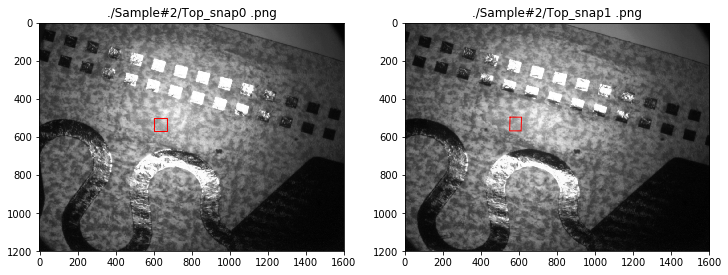

In [112]:
A_opt = res.x.reshape(A_init.shape)
box_prime = affine(box_polyline, A_opt)

# Graph
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(I, cmap = 'gray');
ax2.imshow(J, cmap = 'gray');
ax1.set_title(image_list[k]);
ax2.set_title(image_list[k+1]);
ax1.plot(box_polyline[:, 0], box_polyline[:, 1],
         '-', color='red', linewidth=1, label='box');
ax2.plot(box_prime[:, 0], box_prime[:, 1],
         '-', color='red', linewidth=1, label='box');

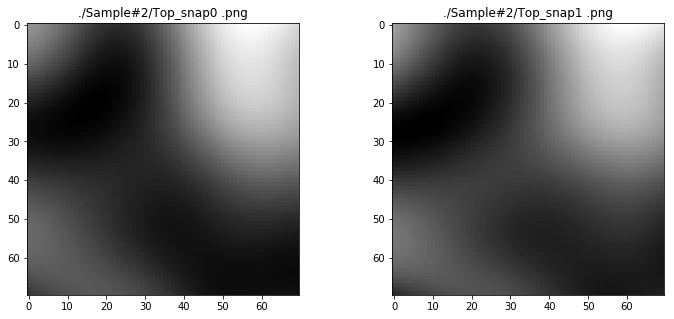

In [113]:
Ibox, Jbox = back_transform(box, A_opt, I_blur, J_blur)
# Graph
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(normalize(Ibox), cmap = 'gray');
ax2.imshow(normalize(Jbox), cmap = 'gray');
ax1.set_title(image_list[k]);
ax2.set_title(image_list[k+1]);